## we see how Q-values are learnt with a fixed beta ##

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In [2]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


In [3]:
class DataSetBeta():
    def __init__(self, rpbgo=10, beta=-.7, size=10**3):
        #rpbgo = rewards per beta-guess-outcome
        self.nbetas=1
        self.beta = beta
        self.betas = np.array([self.beta])
        self.rpbgo=rpbgo
        self.size = size
        d = []
        
        for k in range(self.size):
            proboutcome = Prob(0.4,self.beta,0)
            outcome = np.random.choice([0.,1.],1,p=[proboutcome, 1-proboutcome])[0]
            guess = np.random.choice([-1,1],1)[0]
            mean_bernoulli = qval(self.beta, outcome, guess)
            reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
            d.append([self.beta, outcome, guess, reward])
        self.data_unsplitted = np.array(d)
    
    def BatchSizeSplit(self, batch_size):
        dataset = self.data_unsplitted.copy()
        splits = int(len(dataset)/batch_size)
        if len(dataset)%batch_size !=0:
            #print("Not divisible!: breaking into len(dataset)%batch_size")
            splits = int(len(dataset)/batch_size)
            sobra = int(len(dataset)%batch_size)
            splited = np.split(dataset[sobra:], splits + len(dataset[sobra:])%splits)
            return splited, len(splited[0])
        else:
            splited = np.split(dataset, splits + len(dataset)%splits)
            return splited, len(splited[0])


In [5]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
 #       feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l2(feat))
#        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name

    

In [8]:
net = Net()
optimizer = tf.keras.optimizers.Adam(lr=0.001)

dataset = DataSetBeta(10**3)
splitted_ds, batch_size = dataset.BatchSizeSplit(10)


In [17]:
net(splitted_ds[0][:,[0,1,2]])

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.49656281],
       [0.49655429],
       [0.49641272],
       [0.49641272],
       [0.49656281],
       [0.49655429],
       [0.49655429],
       [0.49655429],
       [0.49655429],
       [0.49641272]])>

In [23]:
preds =net(np.expand_dims(splitted_ds[0][:,[0,1,2]],axis=0))
res = np.expand_dims(splitted_ds[0][:,3],axis=0)
tf.keras.losses.MSE(res,preds)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[0.25069925, 0.25070102, 0.25073033, 0.25073033, 0.25069925,
        0.25070102, 0.25070102, 0.25070102, 0.25070102, 0.25073033]])>

In [25]:
preds =net(np.expand_dims(splitted_ds[0][:,[0,1,2]],axis=1))
res = np.expand_dims(splitted_ds[0][:,3],axis=0)
tf.keras.losses.MSE(res,preds)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.25069925],
       [0.25070102],
       [0.25073033],
       [0.25073033],
       [0.25069925],
       [0.25070102],
       [0.25070102],
       [0.25070102],
       [0.25070102],
       [0.25073033]])>

In [35]:

def training(batch_size=10.):
    net = Net()
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    dataset = DataSetBeta(10**3)
    splitted_ds, batch_size = dataset.BatchSizeSplit(batch_size)
    
    net(np.expand_dims(splitted_ds[0][:,[0,1,2]],axis=0)) #initialize the network

    print("batch_size: ",batch_size)
    histo_preds = {} #here i save the predictions
    loss_ev = []

    epochs=10
    for epoch in tqdm(range(10)):
        losses=[]
        for mini_batch in splitted_ds:
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(np.expand_dims(mini_batch[:,[0,1,2]],axis=0))
                rew = np.expand_dims(mini_batch[:,3],axis=0)
                loss = tf.keras.losses.MSE(rew,preds)
                loss = tf.reduce_mean(loss)
                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
                losses.append(loss)
        loss_ev.append(np.mean(np.array(losses)))
        
        splitted_ds, batch_size = dataset.BatchSizeSplit(batch_size)


        histo_preds[str(epoch)] ={} 
        histo_preds[str(epoch)]["epoch_number"] = epoch
        histo_preds[str(epoch)]["values"] = {}

        index=0
        for n1 in [0.,1.]:
            for guess in [-1.,1.]:
                foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                index+=1

    return loss_ev, histo_preds, net

In [36]:
results = {}
batches = [2]
for batch_size in batches:
    results[str(batch_size)] = training(batch_size)
    

batch_size:  2


In [37]:
results["2"]

([0.23689738583530368,
  0.22543942795689434,
  0.2208790550376345,
  0.2205932566905937,
  0.22038954894623128,
  0.22036427678463866,
  0.2203264108262361,
  0.22030458648264514,
  0.2202860779174439,
  0.2202572206825841],
 {'0': {'epoch_number': 0,
   'values': {'0': array(0.39594385),
    '1': array(0.43963317),
    '2': array(0.36418753),
    '3': array(0.7611918)}},
  '1': {'epoch_number': 1,
   'values': {'0': array(0.50361992),
    '1': array(0.41424458),
    '2': array(0.34936713),
    '3': array(0.76701665)}},
  '2': {'epoch_number': 2,
   'values': {'0': array(0.58672839),
    '1': array(0.36715355),
    '2': array(0.28944356),
    '3': array(0.7654687)}},
  '3': {'epoch_number': 3,
   'values': {'0': array(0.59826039),
    '1': array(0.3705459),
    '2': array(0.29799307),
    '3': array(0.76664875)}},
  '4': {'epoch_number': 4,
   'values': {'0': array(0.5982808),
    '1': array(0.36835006),
    '2': array(0.29808893),
    '3': array(0.76585468)}},
  '5': {'epoch_number':

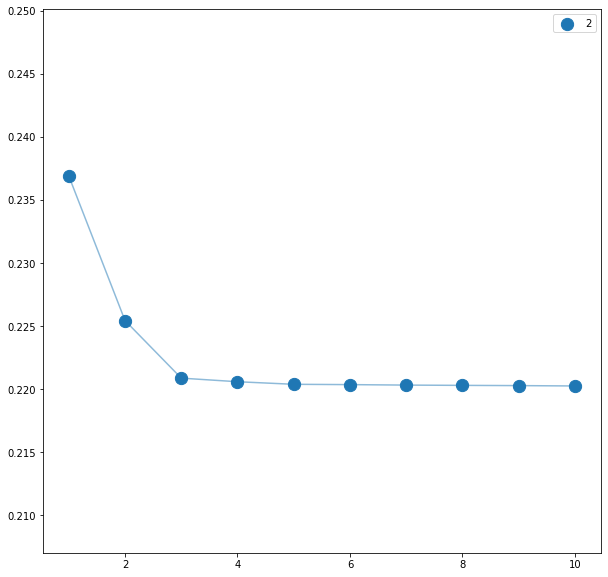

In [38]:
plt.figure(figsize=(10,10))
for k in results.keys():
    loss = results[k][0]
    plt.scatter(np.arange(1,len(loss)+1), loss, s=150, label=k)
    plt.plot(np.arange(1,len(loss)+1), loss, alpha=0.5)
plt.legend()

### looking at the predictions and comparing with the true Q-value ###

In [39]:
def outc(index):
    if index in [0,1]:
        return 0
    else:
        return 1
    
for k in results.keys():
    histo_preds = results[k][1]
    last_epoch = list(histo_preds.keys())[-1]
    last_epoch_preds = histo_preds[str(last_epoch)]
    print("batch_size: ",k)
    for index in range(4):
        print("n: {}, guess: {}".format(outc(index), (-1)**(index+1) ))
        print("pred: {}".format(last_epoch_preds["values"][str(index)]))
        print("true value: {}".format( qval(-.7, outc(index), (-1)**(index+1))))
        print("difference: ",last_epoch_preds["values"][str(index)] - qval(-.7, outc(index), (-1)**(index+1)))
        print("----")
    print("  ")
    print(" ***** ")

batch_size:  2
n: 0, guess: -1
pred: 0.5997145408865314
true value: 0.7539887164489482
-0.15427417556241674
----
n: 0, guess: 1
pred: 0.36504452014071626
true value: 0.2460112835510519
0.11903323658966436
----
n: 1, guess: -1
pred: 0.3041657094050227
true value: 0.1092421935209539
0.19492351588406878
----
n: 1, guess: 1
pred: 0.7646682291243099
true value: 0.8907578064790461
-0.12608957735473625
----
  
 ***** 


In [ ]:
 0.5016096902472228+